# Instalação das bibliotecas necessárias

In [35]:
%pip install matplotlib --quiet
%pip install numpy --quiet
%pip install pandas --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Setup do ambiente

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import gc
import time
import tracemalloc
import os

from src.guloso import labirinto_gulosos
from src.backtracking import labirinto_backtracking

## Função de geração de dados

In [37]:
def gerar_labirinto(linhas, colunas, passagens_extras=True):
    # Garante que as dimensões sejam ímpares
    if linhas % 2 == 0:
        linhas += 1
    if colunas % 2 == 0:
        colunas += 1

    # Inicializa o labirinto todo com paredes (1)
    labirinto = [[1 for _ in range(colunas)] for _ in range(linhas)]

    # Gera a lista de células válidas para caminhos (ímpares)
    def vizinhos_validos(x, y):
        vizinhos = []
        for dx, dy in [(-2, 0), (2, 0), (0, -2), (0, 2)]:
            nx, ny = x + dx, y + dy
            if 1 <= nx < linhas - 1 and 1 <= ny < colunas - 1:
                if labirinto[nx][ny] == 1:
                    vizinhos.append((nx, ny))
        random.shuffle(vizinhos)
        return vizinhos

    def dfs(start_x, start_y):
        stack = [(start_x, start_y)]
        labirinto[start_x][start_y] = 0
        
        while stack:
            x, y = stack[-1]
            vizinhos = vizinhos_validos(x, y)
            
            if not vizinhos:
                stack.pop()
                continue
            
            nx, ny = vizinhos[0]
            if labirinto[nx][ny] == 1:
                labirinto[(x + nx) // 2][(y + ny) // 2] = 0
                labirinto[nx][ny] = 0
                stack.append((nx, ny))
            else:
                stack.pop()
    
    # Define entrada
    entrada_x = random.randrange(1, linhas - 1, 2)
    entrada_y = 0  # A entrada está na borda esquerda
    labirinto[entrada_x][entrada_y] = 0

    # Define uma saída garantida na borda direita
    saida_x = random.randrange(1, linhas - 1, 2)
    saida_y = colunas - 1
    
    # Inicia DFS a partir da entrada para garantir um caminho principal
    dfs(entrada_x, 1)
    
    # Garante que existe pelo menos uma saída acessível
    labirinto[saida_x][saida_y] = 0
    
    # Se a célula adjacente à saída for parede, cria uma passagem
    if labirinto[saida_x][saida_y - 1] == 1:
        labirinto[saida_x][saida_y - 1] = 0
    
    # Adiciona passagens extras aleatórias para criar ramificações
    def adicionar_passagens_extras(tentativas=0.05):
        total = int(linhas * colunas * tentativas)
        for _ in range(total):
            x = random.randrange(1, linhas - 1, 2)
            y = random.randrange(1, colunas - 1, 2)
            dirs = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            random.shuffle(dirs)
            for dx, dy in dirs:
                nx, ny = x + dx, y + dy
                if 0 < nx < linhas - 1 and 0 < ny < colunas - 1:
                    if labirinto[nx][ny] == 1:
                        labirinto[nx][ny] = 0
                        break

    if passagens_extras:
        adicionar_passagens_extras()
    saidas = [(saida_x, saida_y)]
    
    return labirinto, (entrada_x, entrada_y), saidas


## Função de plotagem

In [38]:
def plot_maze(maze, entrance, saidas, saida_em_arquivo=False):
    maze_array = np.array(maze)
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array, cmap='binary', interpolation='nearest')
    
    plt.xticks([]), plt.yticks([])
    plt.gca().invert_yaxis()
    
    plt.scatter(entrance[1], entrance[0], color='green', label='Entrada', s=100)
    for end in saidas:
        plt.scatter(end[1], end[0], color='red', label='Saída', s=100)
    
    plt.title('Labirinto Gerado')
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()

In [39]:
def plot_maze_with_caminhos(maze, caminho_guloso, caminho_backtracking, start, end, saida_em_arquivo=False):
    maze_array = np.array(maze)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    
    ax1.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.invert_yaxis()
    
    for (x, y) in caminho_guloso:
        ax1.scatter(y, x, color='blue', s=20)
    
    ax1.scatter(start[1], start[0], color='green', s=100)
    ax1.scatter(end[1], end[0], color='red', s=100)
    ax1.set_title('Algoritmo Guloso')
    
    ax2.imshow(maze_array, cmap='binary', interpolation='nearest')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.invert_yaxis()

    for (x, y) in caminho_backtracking:
        ax2.scatter(y, x, color='orange', s=20)
    
    ax2.scatter(start[1], start[0], color='green', s=100)
    ax2.scatter(end[1], end[0], color='red', s=100)
    ax2.set_title('Algoritmo Backtracking')
    
    plt.tight_layout()
    
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()


In [40]:
def gerar_graficos(data, titulo, saida_em_arquivo=False):
    # Converte os dados de tempo e memória para float
    data["Tempo"] = data["Tempo"].astype(float)
    data["Memoria"] = data["Memoria"].astype(float)
    data["Qtd"] = data["Qtd"].astype(int)

    # Configura os gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(titulo, fontsize=16)
    
    # Configura o formatador para evitar notação científica nos eixos
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    formatter.set_useOffset(False)

    # Gráfico de Temp
    axes[0].plot(data["Qtd"], data["Tempo"], marker='o', label="Tempo")
    axes[0].set_title("Tempo de Execução")
    axes[0].set_xlabel("Quantidade de Palavras")
    axes[0].set_ylabel("Tempo (s)")
    axes[0].grid(True)
    axes[0].legend()
    axes[0].yaxis.set_major_formatter(formatter)

    # Gráfico de Memória
    axes[1].plot(data["Qtd"], data["Memoria"], marker='o', color='orange', label="Memória")
    axes[1].set_title("Uso de Memória")
    axes[1].set_xlabel("Quantidade de letras")
    axes[1].set_ylabel("Memória (KB)")
    axes[1].grid(True)
    axes[1].legend()
    axes[1].yaxis.set_major_formatter(formatter)

    # Exibe os valores reais nos gráficos formatados
    for i, row in data.iterrows():
        axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='right')  # Formata para 4 casas decimais
        axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='right')  # Formata para 2 casas decimais

    plt.tight_layout()
    if saida_em_arquivo:
        os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
        plt.savefig(saida_em_arquivo)
        plt.close()
    else:
        plt.show()

In [41]:
def gerar_graficos_comparativos(data1, data2, label1="Método 1", label2="Método 2", saida_em_arquivo=False):
  # Converte os dados de tempo e memória para float
  data1["Tempo"] = data1["Tempo"].astype(float)
  data1["Memoria"] = data1["Memoria"].astype(float)
  data1["Qtd"] = data1["Qtd"].astype(int)

  data2["Tempo"] = data2["Tempo"].astype(float)
  data2["Memoria"] = data2["Memoria"].astype(float)
  data2["Qtd"] = data2["Qtd"].astype(int)

  # Configura os gráficos lado a lado
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # Configura o formatador para evitar notação científica nos eixos
  formatter = ScalarFormatter()
  formatter.set_scientific(False)
  formatter.set_useOffset(False)

  # Gráfico de Tempo
  axes[0].plot(data1["Qtd"], data1["Tempo"], marker='o', label=label1)
  axes[0].plot(data2["Qtd"], data2["Tempo"], marker='o', label=label2)
  axes[0].set_title("Comparativo de Tempo de Execução")
  axes[0].set_xlabel("Proporção do Labirinto")
  axes[0].set_ylabel("Tempo (s)")
  axes[0].grid(True)
  axes[0].legend()
  axes[0].yaxis.set_major_formatter(formatter)

  # Gráfico de Memória
  axes[1].plot(data1["Qtd"], data1["Memoria"], marker='o', label=label1)
  axes[1].plot(data2["Qtd"], data2["Memoria"], marker='o', label=label2)
  axes[1].set_title("Comparativo de Uso de Memória")
  axes[1].set_xlabel("Proporção do Labirinto")
  axes[1].set_ylabel("Memória (KB)")
  axes[1].grid(True)
  axes[1].legend()
  axes[1].yaxis.set_major_formatter(formatter)

  # Exibe os valores reais nos gráficos formatados
  # for i, row in data1.iterrows():
  #   axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='right')
  #   axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='right')

  # for i, row in data2.iterrows():
  #   axes[0].text(row["Qtd"], row["Tempo"], f"{row['Tempo']:.6f}", fontsize=9, ha='left')
  #   axes[1].text(row["Qtd"], row["Memoria"], f"{row['Memoria']:.2f}", fontsize=9, ha='left')

  plt.tight_layout()
  
  if saida_em_arquivo:
      os.makedirs(os.path.dirname(saida_em_arquivo), exist_ok=True)
      plt.savefig(saida_em_arquivo)
      plt.close()
  else:
      plt.show()

## Funções para testes

In [42]:
def measure_performance(func, args):
    gc.collect()  # Força coleta de lixo antes da medição
    
    # Mede tempo
    inicio = time.time()
    
    # Mede memória
    tracemalloc.start()
    result = func(*args)  # Desempacota os argumentos do tuple
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Calcula tempo
    fim = time.time()
    tempo = fim - inicio
    
    return result, tempo, peak / 1024

In [43]:
def caminho_guloso(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    _,tempo,memoria = measure_performance(labirinto_gulosos, (maze, start[0], start[1], caminho, visitado, end))
    return caminho,tempo,memoria

def caminho_backtracking(maze, start, end):
    caminho = []
    visitado = [[False]*len(maze[0]) for _ in range(len(maze))]
    _,tempo,memoria = measure_performance(labirinto_backtracking, (maze, start[0], start[1], caminho, visitado, end))
    return caminho, tempo, memoria

In [44]:
def formatar_dados(results):
    return pd.DataFrame(results, columns=['Qtd', 'Tempo', 'Memoria'])

# Gerar caminhos

In [45]:
teste = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

In [46]:
labirintos_varios_caminhos = []
labirintos_um_caminho = []

for i in teste:
    labirinto_varios, start, ends = gerar_labirinto(i, i)
    labirintos_varios_caminhos.append((labirinto_varios,start, ends))
    plot_maze(labirinto_varios, start, ends, f"results/labirinto/original/varios/labirinto_varios_{i}x{i}.png")
    
    labirinto_um, start, ends = gerar_labirinto(i, i, passagens_extras=False)
    labirintos_um_caminho.append((labirinto_um,start, ends))
    plot_maze(labirinto_um, start, ends, f"results/labirinto/original/um/labirinto_um_{i}x{i}.png")

    print(f"Labirinto {i}x{i} gerado com sucesso.")

Labirinto 10x10 gerado com sucesso.
Labirinto 20x20 gerado com sucesso.
Labirinto 30x30 gerado com sucesso.
Labirinto 40x40 gerado com sucesso.
Labirinto 50x50 gerado com sucesso.
Labirinto 60x60 gerado com sucesso.
Labirinto 70x70 gerado com sucesso.
Labirinto 80x80 gerado com sucesso.
Labirinto 90x90 gerado com sucesso.
Labirinto 100x100 gerado com sucesso.
Labirinto 110x110 gerado com sucesso.
Labirinto 120x120 gerado com sucesso.
Labirinto 130x130 gerado com sucesso.
Labirinto 140x140 gerado com sucesso.
Labirinto 150x150 gerado com sucesso.


# Gerando testes para caminhos

In [47]:
resultados_guloso_only = []
resultados_backtracking_only = []

resultados_guloso_mult = []
resultados_backtracking_mult = []


for labirinto_only, labirinto_mult in zip(labirintos_um_caminho, labirintos_varios_caminhos):
    maze_only, start_only, ends_only = labirinto_only
    maze_mult, start_mult, ends_mult = labirinto_mult

    args_cam_only = (maze_only, start_only, ends_only[0])
    args_plt_only = (maze_only, start_only, ends_only)
    
    args_cam_mult = (maze_mult, start_mult, ends_mult[0])
    args_plt_mult = (maze_mult, start_mult, ends_mult)

    caminho_guloso_caminho_only, tempo_guloso_only, memoria_guloso_only = caminho_guloso(*args_cam_only)
    caminho_backtracking_caminho, tempo_backtracking, memoria_backtracking = caminho_backtracking(*args_cam_only)
    
    caminho_guloso_caminho_mult, tempo_guloso_mult, memoria_guloso_mult = caminho_guloso(*args_cam_mult)
    caminho_backtracking_caminho_mult, tempo_backtracking_mult, memoria_backtracking_mult = caminho_backtracking(*args_cam_mult)
    
    plot_maze_with_caminhos(maze_only, caminho_guloso_caminho_only, caminho_backtracking_caminho, start_only, ends_only[0], f"results/labirinto/solucao_labirinto/um/labirinto_um_{len(maze_only)-1}x{len(maze_only)-1}.png")
    plot_maze_with_caminhos(maze_mult, caminho_guloso_caminho_mult, caminho_backtracking_caminho_mult, start_mult, ends_mult[0], f"results/labirinto/solucao_labirinto/varios/labirinto_varios_{len(maze_mult)-1}x{len(maze_mult)-1}.png")

    resultados_guloso_only.append((len(maze_only)-1, tempo_guloso_only, memoria_guloso_only))
    resultados_backtracking_only.append((len(maze_only)-1, tempo_backtracking, memoria_backtracking))
    
    resultados_guloso_mult.append((len(maze_mult)-1, tempo_guloso_mult, memoria_guloso_mult))
    resultados_backtracking_mult.append((len(maze_mult)-1, tempo_backtracking_mult, memoria_backtracking_mult))
    

print("Resultados do Algoritmo Guloso:")
for i in resultados_guloso_only:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo: {i[1]:.4f}s, Memória: {i[2]:.2f}KB")
    
print("\nResultados do Algoritmo Backtracking:")
for i in resultados_backtracking_only:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo: {i[1]:.4f}s, Memória: {i[2]:.2f}KB")

print("\nResultados do Algoritmo Guloso (Múltiplos Caminhos):")
for i in resultados_guloso_mult:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo: {i[1]:.4f}s, Memória: {i[2]:.2f}KB")
    
print("\nResultados do Algoritmo Backtracking (Múltiplos Caminhos):")
for i in resultados_backtracking_mult:
    print(f"Labirinto {i[0]}x{i[0]}: Tempo: {i[1]:.4f}s, Memória: {i[2]:.2f}KB")


Resultados do Algoritmo Guloso:
Labirinto 10x10: Tempo: 0.0004s, Memória: 4.34KB
Labirinto 20x20: Tempo: 0.0003s, Memória: 5.55KB
Labirinto 30x30: Tempo: 0.0010s, Memória: 26.00KB
Labirinto 40x40: Tempo: 0.0018s, Memória: 46.55KB
Labirinto 50x50: Tempo: 0.0042s, Memória: 105.23KB
Labirinto 60x60: Tempo: 0.0015s, Memória: 32.70KB
Labirinto 70x70: Tempo: 0.0018s, Memória: 44.41KB
Labirinto 80x80: Tempo: 0.0114s, Memória: 268.35KB
Labirinto 90x90: Tempo: 0.0117s, Memória: 319.61KB
Labirinto 100x100: Tempo: 0.0045s, Memória: 123.12KB
Labirinto 110x110: Tempo: 0.0120s, Memória: 288.28KB
Labirinto 120x120: Tempo: 0.0083s, Memória: 278.91KB
Labirinto 130x130: Tempo: 0.0293s, Memória: 534.55KB
Labirinto 140x140: Tempo: 0.0194s, Memória: 528.47KB
Labirinto 150x150: Tempo: 0.0395s, Memória: 1058.64KB

Resultados do Algoritmo Backtracking:
Labirinto 10x10: Tempo: 0.0006s, Memória: 28.29KB
Labirinto 20x20: Tempo: 0.0015s, Memória: 87.22KB
Labirinto 30x30: Tempo: 0.0047s, Memória: 508.30KB
Labirint

# Exibição de resultados de teste

In [48]:
dados_algoritmo_guloso_only = formatar_dados(resultados_guloso_only)
dados_algoritmo_backtracking_only = formatar_dados(resultados_backtracking_only)
dados_algoritmo_guloso_mult = formatar_dados(resultados_guloso_mult)
dados_algoritmo_backtracking_mult = formatar_dados(resultados_backtracking_mult)
len(dados_algoritmo_guloso_only), len(dados_algoritmo_backtracking_only), len(dados_algoritmo_guloso_mult), len(dados_algoritmo_backtracking_mult)

(15, 15, 15, 15)

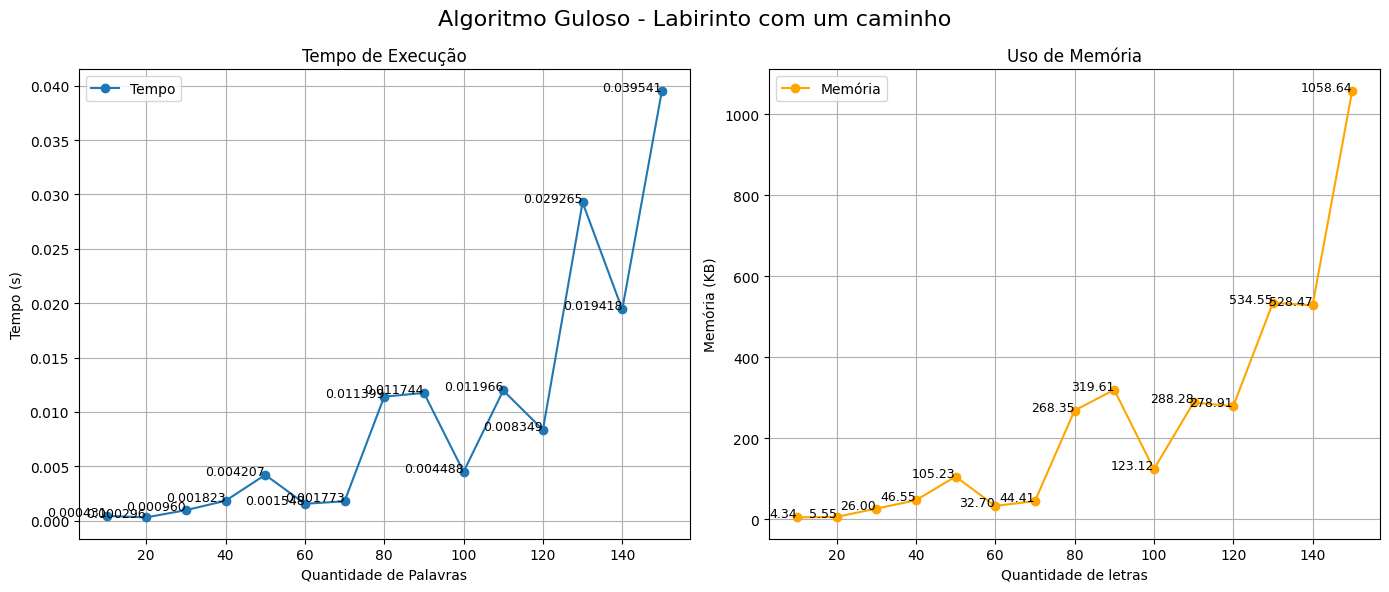

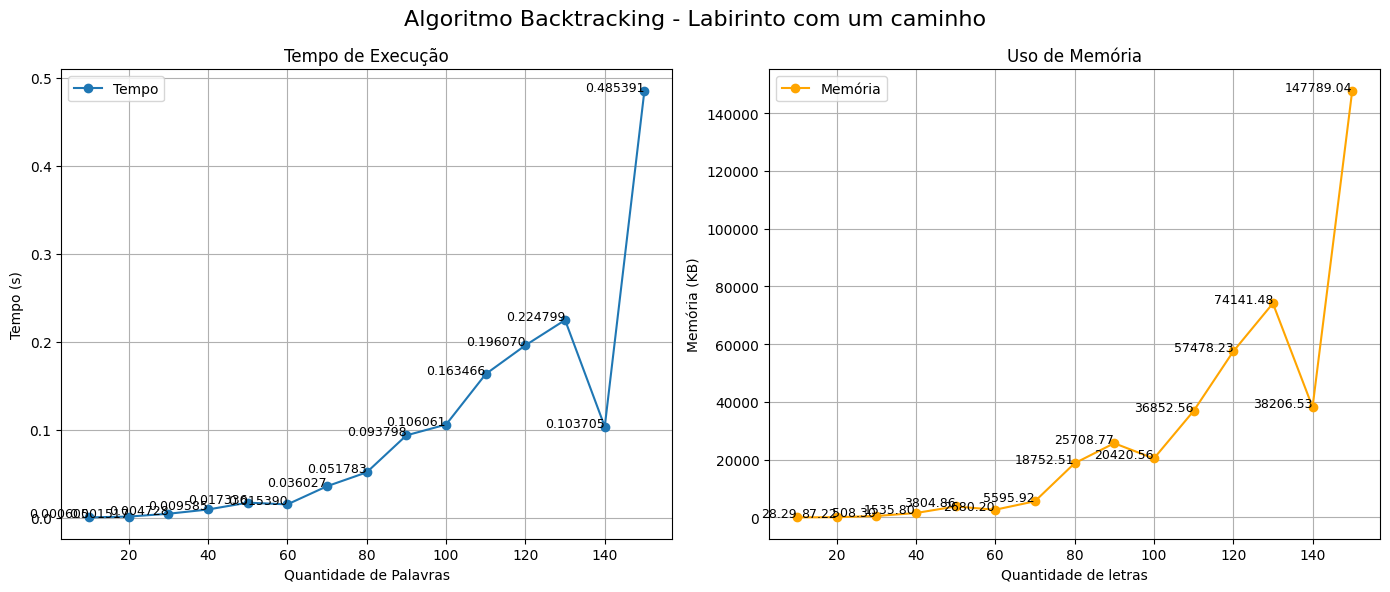

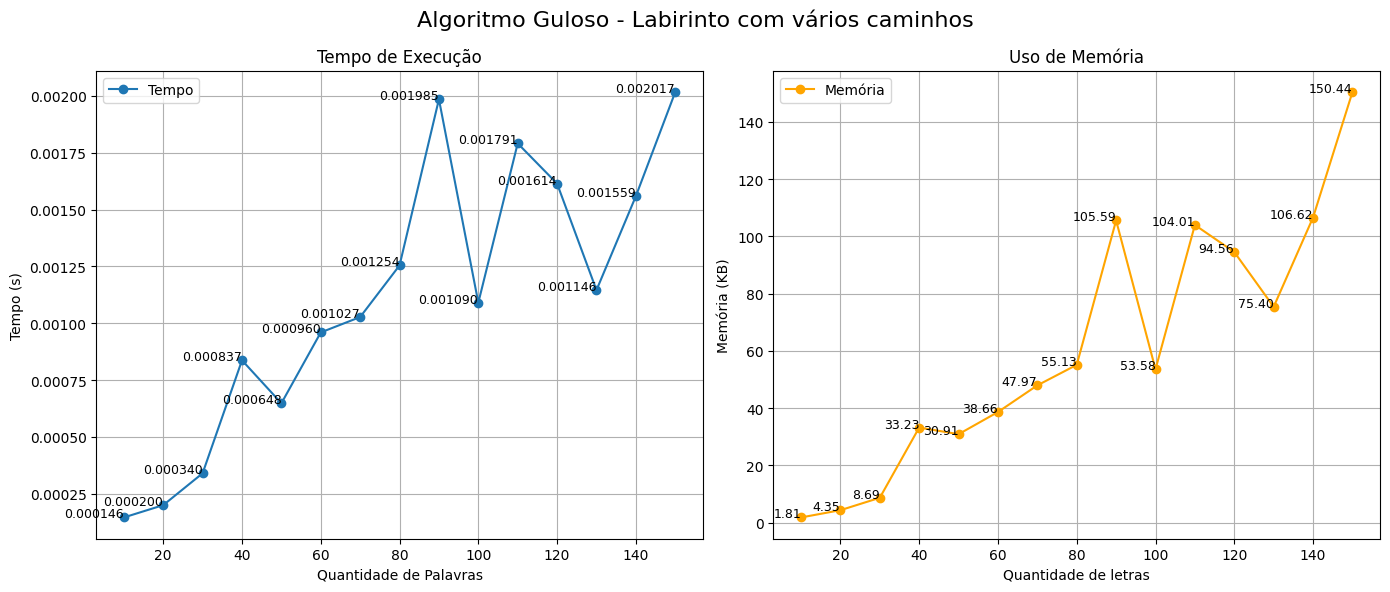

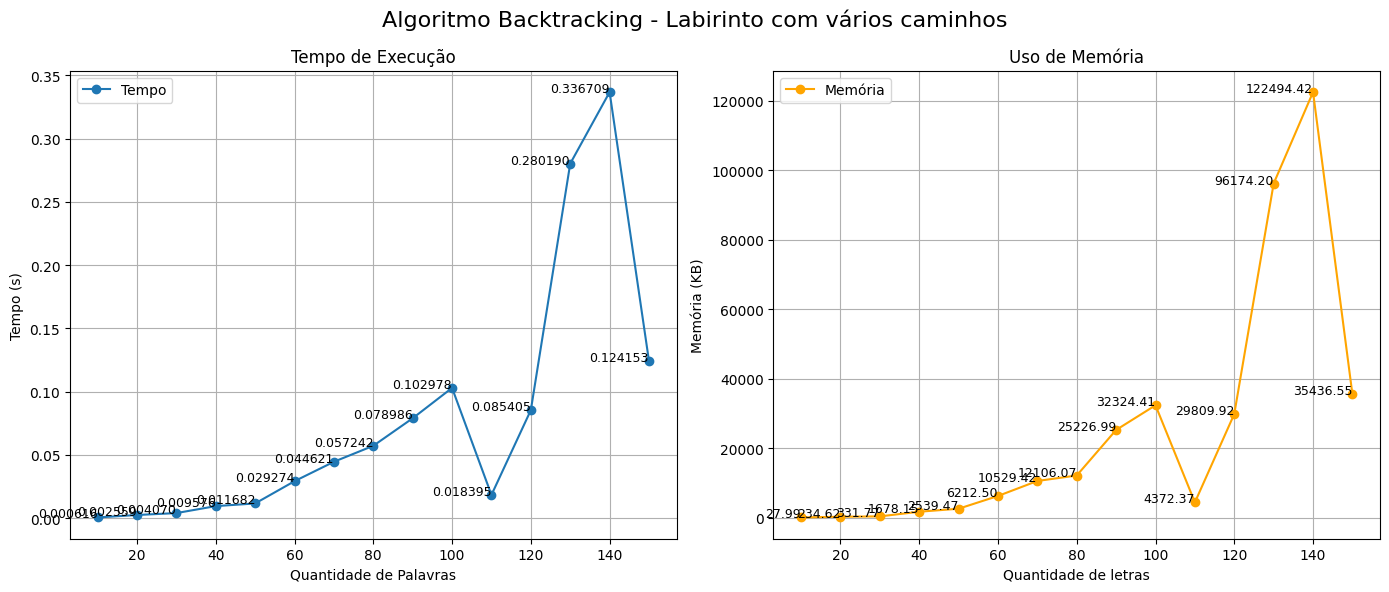

In [49]:
gerar_graficos(dados_algoritmo_guloso_only, "Algoritmo Guloso - Labirinto com um caminho")
gerar_graficos(dados_algoritmo_backtracking_only, "Algoritmo Backtracking - Labirinto com um caminho")
gerar_graficos(dados_algoritmo_guloso_mult, "Algoritmo Guloso - Labirinto com vários caminhos")
gerar_graficos(dados_algoritmo_backtracking_mult, "Algoritmo Backtracking - Labirinto com vários caminhos")

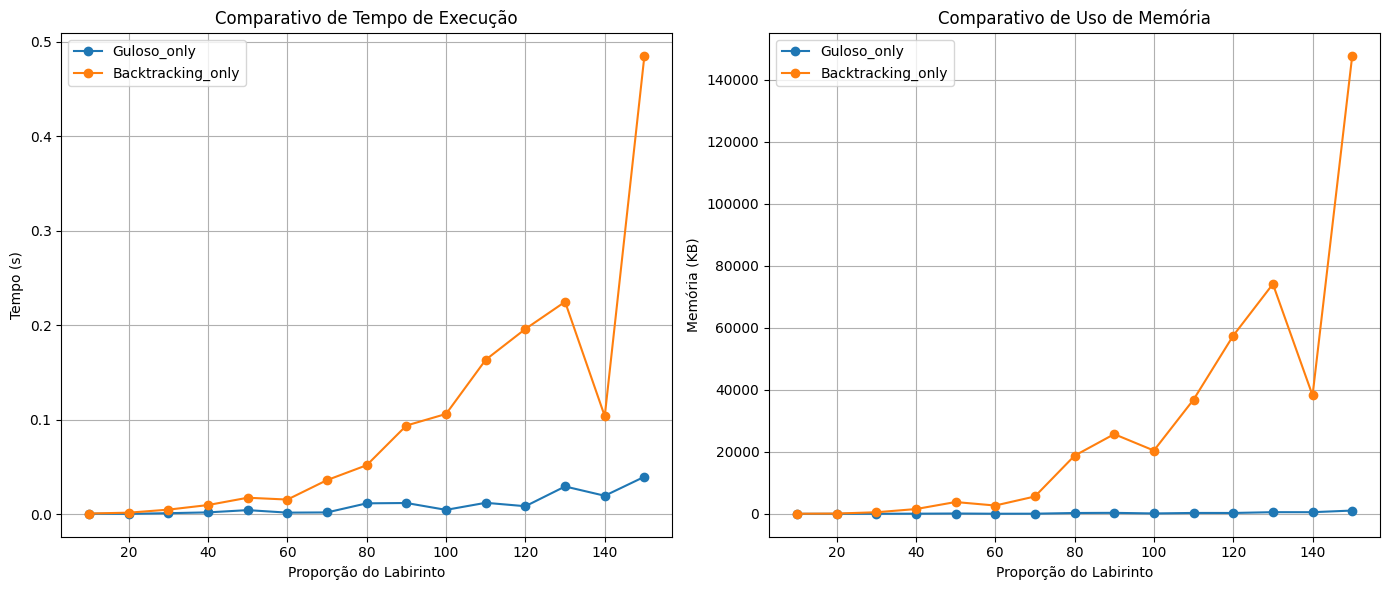

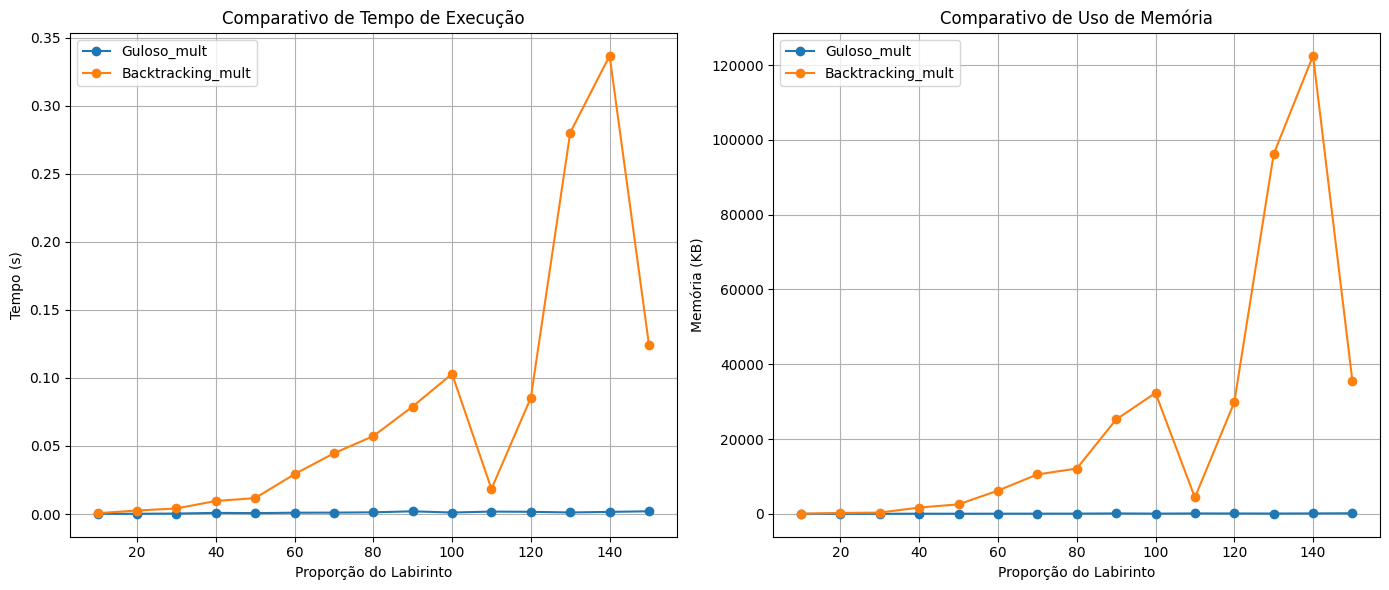

In [50]:
gerar_graficos_comparativos(dados_algoritmo_guloso_only, dados_algoritmo_backtracking_only, label1="Guloso_only", label2="Backtracking_only")
gerar_graficos_comparativos(dados_algoritmo_guloso_mult, dados_algoritmo_backtracking_mult, label1="Guloso_mult", label2="Backtracking_mult")